# Consumer Price Index analysis

By Ben Welsh

A rudimentary analysis of the Consumer Price Index published by the U.S. Bureau of Labor Statistics. It was developed to verify the accuracy of the [cpi](https://github.com/datadesk/cpi) open-source Python wrapper that eases access to the official government data. 

### Import Python tools

In [1]:
import os
import pandas as pd
import altair as alt
from datetime import datetime, timedelta

### Import the development version of this library

In [2]:
import os
import sys
this_dir = os.path.dirname(os.getcwd())
sys.path.insert(0, this_dir)
import cpi

### Match category analysis published by the BLS

In an October 2018 [post](https://www.bls.gov/opub/ted/2018/consumer-prices-up-2-point-3-percent-over-year-ended-september-2018.htm) the BLS published the following chart showing the month to month percentage change in the Consumer Price Index for All Urban Consumers across a select group of categories. We will replicate it below.

![](https://i.imgur.com/54RcrID.png)

Query the three data series charted by the BLS

In [13]:
all_items = cpi.series.get().to_dataframe()

In [14]:
energy = cpi.series.get(items="Energy").to_dataframe()

In [15]:
food = cpi.series.get(items="Food").to_dataframe()

Write a function to prepare each series for presentation

In [38]:
def prep_series(df):
    # Trim down to monthly values
    df = df[df.period_type == 'monthly']
    # Calculate percentage change year to year
    df['pct_change'] = (df.value.pct_change(12)*100)
    # Round the values like BLS
    df['pct_change_rounded'] = df['pct_change'].round(1)
    # Trim down to the last 13 months
    return df.sort_values("date").tail(12*10)

In [39]:
all_items_prepped = prep_series(all_items)
energy_prepped = prep_series(energy)
food_prepped = prep_series(food)

/home/palewire/.virtualenvs/cpi/lib/python2.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/home/palewire/.virtualenvs/cpi/lib/python2.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


In [45]:
category_df = pd.concat([
    all_items_prepped,
    energy_prepped,
    food_prepped
])

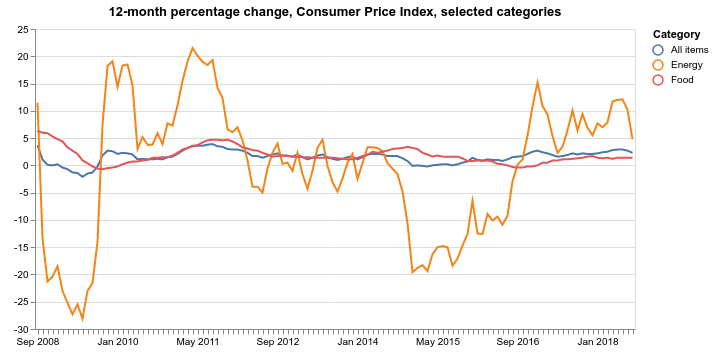

In [50]:
alt.Chart(
    category_df,
    title="12-month percentage change, Consumer Price Index, selected categories"
).mark_line().encode(
    x=alt.X(
        "date:O",
        timeUnit="yearmonth",
        axis=alt.Axis(title=None, labelAngle=0),
    ),
    y=alt.Y(
        "pct_change_rounded:Q",
        axis=alt.Axis(title=None)
    ),
    color=alt.Color(
        "series_items_name:N",
        legend=alt.Legend(title="Category")
    )
).properties(width=600)

### Match monthly analysis published by the BLS.

In a July 2018 [press release](https://www.bls.gov/news.release/pdf/cpi.pdf) the BLS published the following chart showing the month to month percentage change in the Consumer Price Index for All Urban Consumers, also known as the CPI-U. We will replicate it below.

![](https://i.imgur.com/zkLKG5B.png)

Query the seasonally-adjusted CPI-U, which is the variation used by the BLS in its release.

In [3]:
adjusted_cpiu = cpi.series.get_by_id('CUSR0000SA0').to_dataframe()

Add a date field

In [4]:
adjusted_cpiu['date'] = pd.to_datetime(adjusted_cpiu.date)

Filter down to monthly values

In [5]:
adjusted_cpiu.head()

,date,period_abbreviation,period_code,period_id,period_month,period_name,period_type,series_area_code,series_area_id,series_area_name,...,series_items_id,series_items_name,series_periodicity_code,series_periodicity_id,series_periodicity_name,series_seasonally_adjusted,series_survey,series_title,value,year
0,1997-01-01,JAN,M01,M01,1,January,monthly,0000,0000,U.S. city average,...,SA0,All items,R,R,Monthly,True,All urban consumers,"All items in U.S. city average, all urban cons...",159.4,1997
1,1997-02-01,FEB,M02,M02,2,February,monthly,0000,0000,U.S. city average,...,SA0,All items,R,R,Monthly,True,All urban consumers,"All items in U.S. city average, all urban cons...",159.7,1997
2,1997-03-01,MAR,M03,M03,3,March,monthly,0000,0000,U.S. city average,...,SA0,All items,R,R,Monthly,True,All urban consumers,"All items in U.S. city average, all urban cons...",159.8,1997
3,1997-04-01,APR,M04,M04,4,April,monthly,0000,0000,U.S. city average,...,SA0,All items,R,R,Monthly,True,All urban consumers,"All items in U.S. city average, all urban cons...",159.9,1997
4,1997-05-01,MAY,M05,M05,5,May,monthly,0000,0000,U.S. city average,...,SA0,All items,R,R,Monthly,True,All urban consumers,"All items in U.S. city average, all urban cons...",159.9,1997


In [6]:
adjusted_cpiu.period_type.value_counts()

monthly    861
Name: period_type, dtype: int64

In [7]:
adjusted_cpiu = adjusted_cpiu[adjusted_cpiu.period_type == 'monthly']

Calculate the monthly percentage change.

In [8]:
adjusted_cpiu['pct_change'] = (adjusted_cpiu.value.pct_change()*100)

Round it in the same manner as the BLS.

In [9]:
adjusted_cpiu['pct_change_rounded'] = adjusted_cpiu['pct_change'].round(1)

Trim down to the 13 most recent months of data.

In [10]:
last_13 = adjusted_cpiu.sort_values("date").tail(13)

Draw the chart.

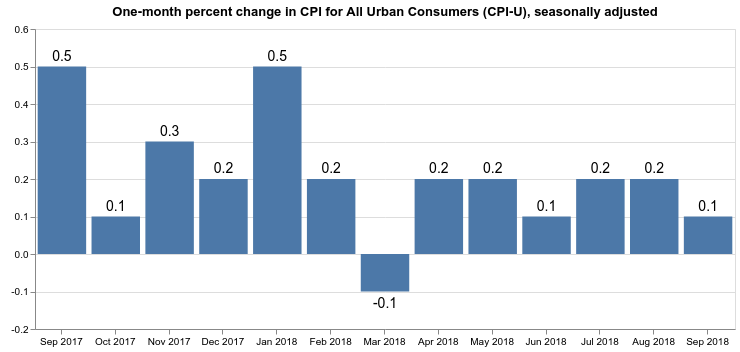

In [11]:
base = alt.Chart(
    last_13, 
    title="One-month percent change in CPI for All Urban Consumers (CPI-U), seasonally adjusted"
).properties(width=700)

bars = base.mark_bar().encode(
    x=alt.X(
        "date:O",
        timeUnit="yearmonth",
        axis=alt.Axis(title=None, labelAngle=0),
    ),
    y=alt.Y(
        "pct_change_rounded:Q",
        axis=alt.Axis(title=None),
        scale=alt.Scale(domain=[
            last_13['pct_change'].min()-0.1,
            last_13['pct_change'].max()+0.05
        ])
    )
)

text = base.encode(
    x=alt.X("date:O", timeUnit="yearmonth"),
    y="pct_change_rounded:Q",
    text='pct_change_rounded'
)

textAbove = text.transform_filter(alt.datum.pct_change > 0).mark_text(
    align='center',
    baseline='middle',
    fontSize=14,
    dy=-10
)

textBelow = text.transform_filter(alt.datum.pct_change < 0).mark_text(
    align='center',
    baseline='middle',
    fontSize=14,
    dy=12
)

bars + textAbove + textBelow

### Dump the file to JSON

In [12]:
last_13.to_json("./last_13.json")